In [7]:
import yfinance as yf
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import pandas as pd
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
class EMACrossStrategy(Strategy):
    n1 = 20  # fast EMA period
    n2 = 50  # slow EMA period

    def init(self):
        # Calculate EMAs
        self.ema1 = self.I(
            lambda x: pd.Series(x).ewm(span=self.n1, adjust=False).mean(),
            self.data.Close,
        )
        self.ema2 = self.I(
            lambda x: pd.Series(x).ewm(span=self.n2, adjust=False).mean(),
            self.data.Close,
        )

    def next(self):
        if crossover(self.ema1, self.ema2):
            self.buy()
        elif crossover(self.ema2, self.ema1):
            self.sell()

In [ ]:
# Download the Data
start_date = "2023-08-12"
end_date = "2024-08-11"
data = yf.download("BTC-USD", start=start_date, end=end_date)
data

In [ ]:
# Create and run the backtest
bt = Backtest(data, EMACrossStrategy, cash=100000, commission=0.002)
stats = bt.run()

# Print results
print(stats)

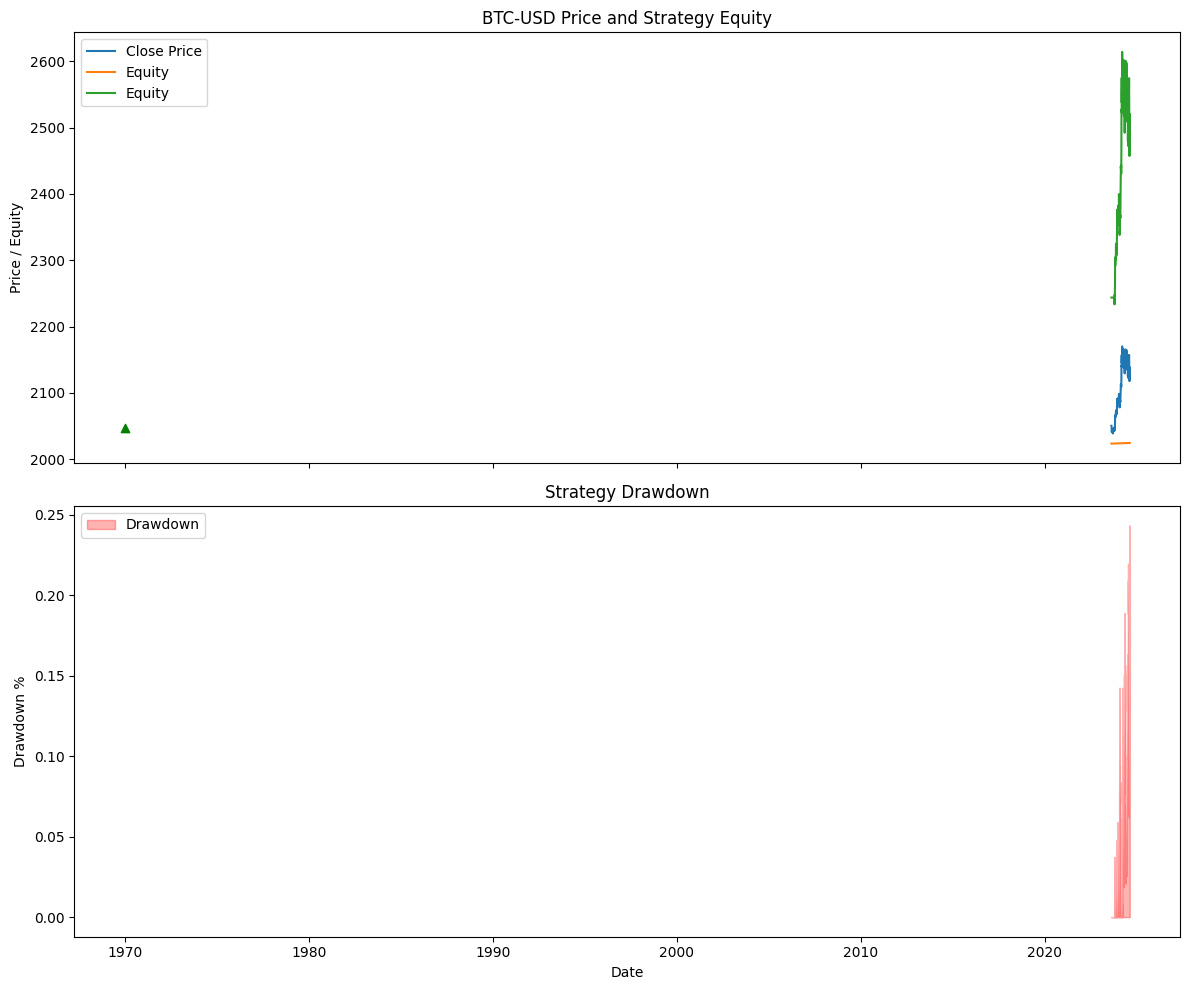

In [8]:
# Custom plotting function
def plot_backtest_results(data, stats):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

    # Plot price and EMAs
    ax1.plot(data.index, data["Close"], label="Close Price")
    ax1.plot(
        data.index,
        stats["_equity_curve"].index,
        stats["_equity_curve"]["Equity"],
        label="Equity",
    )
    ax1.set_title("BTC-USD Price and Strategy Equity")
    ax1.set_ylabel("Price / Equity")
    ax1.legend()

    # Plot buy and sell signals
    buy_signals = stats["_trades"][stats["_trades"]["Size"] > 0]
    sell_signals = stats["_trades"][stats["_trades"]["Size"] < 0]
    ax1.scatter(
        buy_signals.index, buy_signals["EntryPrice"], marker="^", color="g", label="Buy"
    )
    ax1.scatter(
        sell_signals.index,
        sell_signals["EntryPrice"],
        marker="v",
        color="r",
        label="Sell",
    )

    # Plot drawdown
    drawdown = stats["_equity_curve"]["DrawdownPct"]
    ax2.fill_between(
        drawdown.index, drawdown.values, 0, alpha=0.3, color="red", label="Drawdown"
    )
    ax2.set_title("Strategy Drawdown")
    ax2.set_ylabel("Drawdown %")
    ax2.set_xlabel("Date")
    ax2.legend()

    plt.tight_layout()
    plt.show()


# Plot the results
plot_backtest_results(data, stats)